In [1]:
%load_ext autoreload
%autoreload 2
import os; import sys;src_dir = os.path.join(os.getcwd(), os.pardir, 'src');sys.path.append(src_dir)

In [2]:
from data.dal import DAL
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import math

In [5]:
split = DAL("split.hdf")
dfs =[split.get(k) for k in split.overview().df_key]
labels = split.overview()

In [4]:
features = DAL("features.hdf")
features.overview()
angles = features.get("angles_raw")
angles = angles.groupby("id")
angleslist = [v for k,v in angles]


In [24]:
[c for c in angleslist[0].columns if "Knee" in c]
kot = split.overview().execution_type == 2

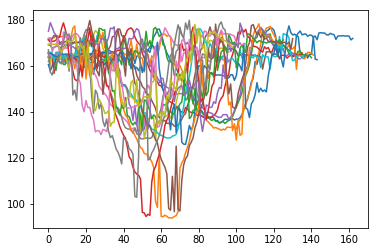

In [36]:
for df,yes in list(zip(angleslist,kot))[:100]:
    if yes:
        plt.plot((180/math.pi)*df['HipLeft_KneeLeft_AnkleLeft'].values)
plt.show()

            df_key  execution_type exercise   person
280  skeleton_3006               3    lunge  vincent


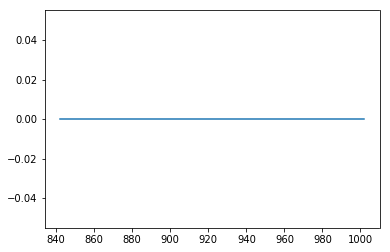

In [123]:
# KOT rule: (kneeleftz + kneeleftrightz) smaller than footleftz and knee

i = 280
df = dfs[i]
print(split.overview()[i:i+1])
plt.plot((df.KneeLeftZ < df.FootLeftZ) & (df.KneeRightZ < df.FootRightZ))
#plt.plot(df.KneeRightZ-df.FootRightZ)
plt.plot()
plt.show()
#for df in dfs:

#print(c.col)

            df_key  execution_type exercise   person
240  skeleton_2606               1    lunge  vincent


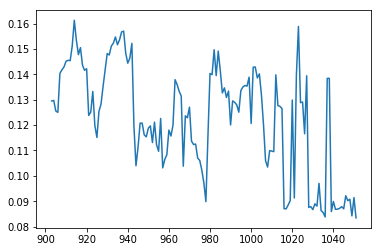

In [130]:
# KK rule: abs((kneeleftX - kneerightY)) < threshold

i = 240
df = dfs[i]
print(split.overview()[i:i+1])
plt.plot(abs((df.KneeLeftX - df.KneeRightX)))
plt.show()

            df_key  execution_type   exercise   person
295  skeleton_3202               1  sidelunge  vincent


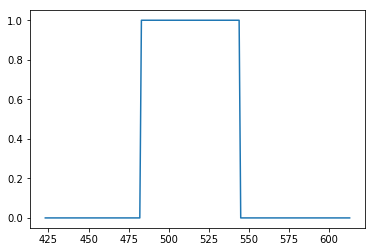

In [143]:
# FTL rule: SpineBaseZ - SpineShoulderZ > threshhold 
df.columns
i = 295
df = dfs[i]
print(split.overview()[i:i+1])
plt.plot(df.SpineBaseZ - df.SpineShoulderZ > 0.15)
plt.show()

In [55]:
import models.rules as ru
from pandas_ml import ConfusionMatrix
import sklearn.metrics

clf = ru.RuleClassifier(0,0,0.23,10)
y = split.overview().execution_type.values
preds = clf.predict(dfs)
print(sklearn.metrics.accuracy_score(y,preds))
sklearn.metrics.confusion_matrix(y,preds)

0.5899441340782123


array([[538,  62,   0, 295],
       [112,  65,   0,  19],
       [135,  16,   0,  43],
       [ 44,   8,   0, 453]])

In [60]:
y == 1
[x == 1 for x in preds]
print(sklearn.metrics.accuracy_score(y==1,[x == 1 for x in preds]))

0.6379888268156425


In [52]:
import models.rules as ru
from sklearn.grid_search import RandomizedSearchCV
import scipy.stats
param_dist = {"poses": range(10,20),
             "ftl_t": [0.23],#scipy.stats.uniform(0,0.5),
             "kk_t": scipy.stats.uniform(0,0.5),
             "kot_t":[0]#scipy.stats.uniform(0,0.5)
             }

# run randomized search
n_iter_search = 50
clf = ru.RuleClassifier()
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search,scoring="accuracy")

X = dfs
y = split.overview().execution_type.values
random_search.fit(X,y)

print(random_search.best_params_)
print(random_search.best_score_)
#random_search
clf = random_search.best_estimator_
preds = clf.predict(dfs)
print(sklearn.metrics.accuracy_score(y,preds))
sklearn.metrics.confusion_matrix(y,preds)

{'ftl_t': 0.23, 'kk_t': 0.04142427044620284, 'kot_t': 0, 'poses': 12}
0.5949720670391061
0.5949720670391061


array([[554,  57,   0, 284],
       [116,  61,   0,  19],
       [138,  13,   0,  43],
       [ 48,   7,   0, 450]])

In [58]:
import scipy

def f(params):
    kot,kk,ftl,poses = params
    clf = ru.RuleClassifier(kot_t=kot,kk_t=kk,ftl_t=ftl,poses=poses)
    preds = clf.predict(dfs)
    return 1 - sklearn.metrics.accuracy_score(y,preds)

initial_guess = [0, 0, 0.23, 10]
result = scipy.optimize.minimize(f, initial_guess, method="Powell",options={"maxiter":30,"disp":True})
#if result.success:
fitted_params = result.x
print(fitted_params)

Optimization terminated successfully.
         Current function value: 0.402235
         Iterations: 4
         Function evaluations: 405
[-7.96379312e-03 -1.47193355e-01  2.35901142e-01  1.10285602e+01]


100%|██████████| 51/51 [00:12<00:00,  4.24it/s]


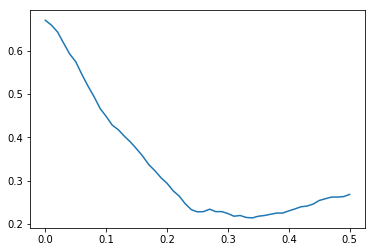

In [34]:
import scipy.optimize
import models.rules as ru
import sklearn.metrics
from tqdm import tqdm

yftl = labels["execution_type"] == 4

def f_ftl(param):
    clf = ru.RuleClassifier(ftl_t=param)
    preds = [clf.is_ftl(df) >= 10 for df in dfs]
    return 1 - sklearn.metrics.accuracy_score(yftl,preds)
x = np.linspace(0,0.5,51)
errors = [f_ftl(xi) for xi in tqdm(x)]
plt.plot(x,errors)
plt.show()
min(zip(errors,x),key=lambda xi : xi[0])[1]
# conclusie: ftl_t == 0.34

100%|██████████| 11/11 [00:03<00:00,  2.81it/s]


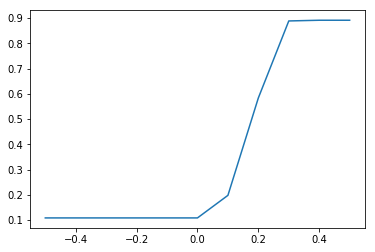

In [43]:
import scipy.optimize
import models.rules as ru
import sklearn.metrics
from tqdm import tqdm

y = labels["execution_type"] == 3

def f(param):
    clf = ru.RuleClassifier(kk_t=param)
    preds = [clf.is_kk(df) >= 10 for df in dfs]
    return 1 - sklearn.metrics.accuracy_score(y,preds)
x = np.linspace(-0.5,0.5,11)
errors = [f(xi) for xi in tqdm(x)]
plt.plot(x,errors)
plt.show()
# conclusie: ftl_t == 0.34


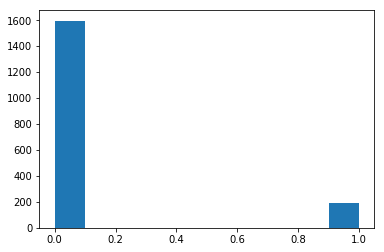

0.10837988826815642


(0.10837988826815648, -0.5)

In [44]:
plt.hist(y)
plt.show()
print(sum(y)/len(y))
min(zip(errors,x),key=lambda xi : xi[0])